In [271]:
import pandas as pd
import random
import numpy as np
import copy
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import collections
from collections import deque, defaultdict

In [272]:
class QuantumNetwork:
    def __init__(self, initialEdges, pGen, pSwap, cutOffAge, nodeCapacity):
        self.initialEdges = initialEdges
        self.pGen = pGen
        self.pSwap = pSwap
        self.cutOffAge = cutOffAge
        self.nodeCapacity = nodeCapacity  # Dictionary mapping node -> max entanglements
        
        self.G = nx.Graph()
        nodes = set()
        for edge in self.initialEdges:
            nodes.add(edge[0])
            nodes.add(edge[1])
        self.G.add_nodes_from(sorted(nodes))
    
    def reset(self):
        self.G = nx.Graph()
        nodes = set()
        for edge in self.initialEdges:
            nodes.add(edge[0])
            nodes.add(edge[1])
        self.G.add_nodes_from(nodes)
    
    def setState(self, state):
        self.G = nx.Graph()
        for edge, entanglements in state.items():
            self.G.add_edge(*edge, entanglements=deque(entanglements))
    
    def getNodeEntanglementCount(self, node):
        return sum(len(self.G.edges[e]['entanglements']) 
                  for e in self.G.edges(node)) if self.G.degree(node) > 0 else 0
        
    def generateLocalEntanglement(self, node1, node2):
        edge = tuple(sorted([node1, node2]))
        
        # Check if either node has reached its capacity
        node1_count = self.getNodeEntanglementCount(node1)
        node2_count = self.getNodeEntanglementCount(node2)
        
        if (node1_count >= self.nodeCapacity[node1] or 
            node2_count >= self.nodeCapacity[node2]):
            return 
        
        if not self.G.has_edge(*edge):
            self.G.add_edge(*edge, entanglements=deque([0]))
        else:
            self.G.edges[edge]['entanglements'].appendleft(0)
            
    def getState(self):
        edge_info = {}
        for edge in self.G.edges():
            edge_info[edge] = list(self.G.edges[edge]['entanglements']) 
        return edge_info
        
    def ageEntanglements(self):
        edges_to_check = list(self.G.edges())  # Create a copy of edges to iterate over
        for edge in edges_to_check:
            entanglements = self.G.edges[edge]['entanglements']
            # Remove entanglements that would exceed cutOffAge
            while entanglements and entanglements[-1] + 1 > self.cutOffAge:
                self.discardEntanglement(edge)
            # Age remaining entanglements
            if self.G.has_edge(*edge):  # Check if edge still exists
                entanglements = self.G.edges[edge]['entanglements']
                self.G.edges[edge]['entanglements'] = deque(age + 1 for age in entanglements)
    
    def generateGlobalEntanglementsProbabalistically(self):
        for edge in self.initialEdges:
            if random.random() < self.pGen:
                self.generateLocalEntanglement(*edge)

    def discardEntanglement(self, edge: tuple):
        if self.G.has_edge(*edge):
            if len(self.G.edges[edge]['entanglements']) > 0:
                self.G.edges[edge]['entanglements'].pop()
            if len(self.G.edges[edge]['entanglements']) == 0:
                self.G.remove_edge(*edge)
                
         
    def drawNetwork(self):
        plt.figure(figsize=(12, 8))
        plt.clf()
        
        G_viz = self.G.copy()
        G_viz.add_edges_from(self.initialEdges)
        
        # FIXED POSITION FOR DUMBELL NETWORK
        pos = {
            0: (-1, 0.5),   # Top left
            1: (-1, -0.5),  # Bottom left
            2: (0, 0),      # Center
            3: (1, 0),      # Center right
            4: (2, 0.5),    # Top right
            5: (2, -0.5)    # Bottom right
        }
        # pos = nx.spring_layout(G_viz, seed=27)

        nx.draw_networkx_edges(G_viz, pos=pos, 
                            edgelist=self.initialEdges,
                            edge_color='grey',
                            style='dashed',
                            alpha=0.5)
        
        for edge in self.G.edges():
            entanglements = self.G.edges[edge]['entanglements']
            for i, age in enumerate(entanglements):
                nx.draw_networkx_edges(G_viz, pos=pos,
                                    edgelist=[edge],
                                    edge_color='blue',
                                    width=2,
                                    arrows=True,
                                    connectionstyle=f'arc3, rad={-0.1 + i*0.2}')
                
                edge_x = (pos[edge[0]][0] + pos[edge[1]][0]) / 2
                edge_y = (pos[edge[0]][1] + pos[edge[1]][1]) / 2
                offset = -0.1 + i*0.2
                label_x = edge_x + offset * (pos[edge[1]][1] - pos[edge[0]][1]) / 2
                label_y = edge_y - offset * (pos[edge[1]][0] - pos[edge[0]][0]) / 2
                plt.text(label_x, label_y, str(age), 
                        bbox=dict(facecolor='white', edgecolor='lightgray', alpha=0.7))
        
        nx.draw_networkx_nodes(G_viz, pos=pos, node_color='lightblue')
        nx.draw_networkx_labels(G_viz, pos=pos)
        
        plt.show()

###############################
###############################
###############################

class WaitSwapEnvironment(QuantumNetwork):
    def __init__(self, initialEdges, pGen, pSwap, cutOffAge, nodeCapacity, goalEdgesAndWeights, n):
        super().__init__(initialEdges, pGen, pSwap, cutOffAge, nodeCapacity)
        self.goalEdgesAndWeights = goalEdgesAndWeights
        self.timestep = 0  # Track total timesteps
        self.sumExists = defaultdict(lambda: 1)  # Track sum of times each goal edge exists
        self.n = n 
        

    def _get_num_elementary_edges(self, start_node, end_node):
        if nx.has_path(self.G, start_node, end_node):
            path = nx.shortest_path(self.G, start_node, end_node)
            num_elementary_edges = len(path) - 1
            return num_elementary_edges
        return None

    def getReward(self):
        total_reward = 0
        log_sum_edr = 0
        
        for goal_edge, weight in self.goalEdgesAndWeights:
            sorted_goal = tuple(sorted(goal_edge))
            
            num_elementary_edges = self._get_num_elementary_edges(sorted_goal[0], sorted_goal[1])
            if num_elementary_edges is not None:
                instantaneousRate = self.pGen ** num_elementary_edges
                if self.timestep > 0:
                    if self.sumExists[sorted_goal] > 0:
                        averageRate = self.sumExists[sorted_goal] / self.timestep
                    else:
                        averageRate = 1 
                else:
                    averageRate = 1
                
                edge_reward = (instantaneousRate / averageRate) * (weight * 10)
                log_sum_edr += np.log(edge_reward)
        
        # Incorporate log sum of EDR into the reward
        total_reward += log_sum_edr
        return total_reward

    def updateRateParameters(self):
        self.timestep += 1
        for goal_edge, _ in self.goalEdgesAndWeights:
            sorted_goal = tuple(sorted(goal_edge))
            if self.G.has_edge(*sorted_goal):
                self.sumExists[sorted_goal] += 1
                
    
    def copy(self):
        new_env = WaitSwapEnvironment(
            initialEdges=self.initialEdges.copy(),  # Use copy to ensure a new list is created
            pGen=self.pGen,
            pSwap=self.pSwap,
            cutOffAge=self.cutOffAge,
            nodeCapacity=self.nodeCapacity,
            goalEdgesAndWeights=self.goalEdgesAndWeights,
            n=self.n,
        )
        
        new_env.G = self.G.copy()
        
        for edge in new_env.G.edges():
            new_env.G.edges[edge]['entanglements'] = deque(self.G.edges[edge]['entanglements'])
        new_env.timestep = self.timestep
        new_env.sumExists = self.sumExists.copy()
        
        return new_env

    def takeAction(self, action):
        swaps, goal = action  # Unpack the tuple
        if swaps:
            max_age = 0
            for edge1, edge2 in swaps:
                if self.G.has_edge(*edge1):
                    max_age = max(max_age, max(self.G.edges[edge1]['entanglements']))
                if self.G.has_edge(*edge2):
                    max_age = max(max_age, max(self.G.edges[edge2]['entanglements']))
                
                self.discardEntanglement(edge1)
                self.discardEntanglement(edge2)

            if goal:
                edge = tuple(sorted(goal))
                if not self.G.has_edge(*edge):
                    self.G.add_edge(*edge, entanglements=deque([max_age]))
                else:
                    self.G.edges[edge]['entanglements'].appendleft(max_age)
    
    def getPossibleActions(self):
        possible_actions = []
        
        for goal_edge, _ in self.goalEdgesAndWeights:
            start_node, end_node = goal_edge
            
            if nx.has_path(self.G, start_node, end_node):
                paths = list(nx.all_simple_paths(self.G, start_node, end_node))
                for path in paths:
                    path_edges = []
                    for i in range(len(path)-1):
                        edge = tuple(sorted([path[i], path[i+1]]))
                        path_edges.append(edge)
                    
                    has_entanglements = all(
                        self.G.has_edge(*edge) or self.G.has_edge(*tuple(reversed(edge)))
                        for edge in path_edges
                    )
                    
                    if has_entanglements:
                        possible_actions.append((
                            [(edge1, edge2) for edge1, edge2 in zip(path_edges[:-1], path_edges[1:])],
                            goal_edge
                        ))
        
        possible_actions.append(([], None))
        return possible_actions
    
    def getActionEpsilonGreedyPolicy(self,Q, state, epsilon):
        actions_and_values = Q.getActionAndValues(state)
        if not actions_and_values:
            possible_actions = self.getPossibleActions()
            return random.choice(possible_actions)
        
        if np.random.rand() < epsilon:
            return random.choice(actions_and_values)[0]
        else:
            return max(actions_and_values, key=lambda x: x[1])[0]

In [273]:
class QTable: 
    def __init__(self):
        self.Q = defaultdict(lambda: defaultdict(lambda: 0.0))
    
    def _state_to_tuple(self, state):
        return tuple(sorted((edge, tuple(sorted(ages))) for edge, ages in state.items()))
    
    def storeStateActionValue(self, state, action, value):
        state_tuple = self._state_to_tuple(state)
        # Convert the second part of the action to a tuple
        action_tuple = (tuple(action[0]), tuple(action[1]) if action[1] is not None else ())
        self.Q[state_tuple][action_tuple] = value

    def getValue(self, state, action):
        # Convert the second part of the action to a tuple
        action_tuple = (tuple(action[0]), tuple(action[1]) if action[1] is not None else ())
        state_tuple = self._state_to_tuple(state)
        return self.Q[state_tuple][action_tuple]

    def getActionAndValues(self, state):
        state_tuple = self._state_to_tuple(state)
        return [(action, value) for action, value in self.Q[state_tuple].items()]


In [274]:
def nStepSARSA(initialEdges, nodeCapacity, goalEdgesAndWeights, gamma, pGen, pSwap, cutOffAge, total_steps, alpha, n, epsilon):
    # Initialize the environment
    network = WaitSwapEnvironment(
        initialEdges=initialEdges,
        pGen=pGen,
        pSwap=pSwap,
        cutOffAge=cutOffAge,
        nodeCapacity=nodeCapacity,
        goalEdgesAndWeights=goalEdgesAndWeights,
        n=n
    )
    
    # Initialize Q-table
    Q = QTable()
    
    # Logging for the EDR
    goal_1, goal_2 = goalEdgesAndWeights[0][0], goalEdgesAndWeights[1][0]
    edr_goal_1, edr_goal_2 = [], []
    log_sum_edr = []

    # Reset and prepare the network for a new run
    network.reset()
    network.generateGlobalEntanglementsProbabalistically()
    
    # Initial states and actions
    states = [network.getState()]
    chosenAction = network.getActionEpsilonGreedyPolicy(Q, states[-1], epsilon)
    actions = [chosenAction]
    rewards = []
    
    for t in range(total_steps):
        # Take action A_{t}, and store next reward and state as R_{t+1}, S_{t+1}
        network.takeAction(actions[-1])
        states.append(network.getState())
        reward = network.getReward()
        rewards.append(reward)
        
        # Choose an action A_{t+1} arbitrarily as a function of S_{t+1}; Store as A_{t+1}
        possibleActions = network.getPossibleActions()
        action = network.getActionEpsilonGreedyPolicy(Q, states[-1], epsilon)
        actions.append(action)
        
        # Take a step
        network.updateRateParameters()
        network.ageEntanglements()
        network.generateGlobalEntanglementsProbabalistically()
        
        #Update rules
        tau = t - n + 1
        if tau >= 0:
            G_1 = rewards[tau]
            if tau + 1 < total_steps:
                next_state = states[tau + 1]
                next_possible_actions = network.getPossibleActions()
                expected_value = 0
                for a in next_possible_actions:
                    action_prob = epsilon / len(next_possible_actions)
                    if a == max(next_possible_actions, key=lambda x: Q.getValue(next_state, x)):
                        action_prob += (1 - epsilon)
                    expected_value += action_prob * Q.getValue(next_state, a)
                G_1 += gamma * expected_value

            G_2 = G_1
            for k in range(t, tau, -1):
                state_k = states[k]
                action_k = actions[k]
                expected_value = 0
                for a in next_possible_actions:
                    if a != action_k:
                        action_prob = epsilon / len(next_possible_actions)
                        if a == max(next_possible_actions, key=lambda x: Q.getValue(state_k, x)):
                            action_prob += (1 - epsilon)
                        expected_value += action_prob * Q.getValue(state_k, a)
                
                action_prob = epsilon / len(next_possible_actions)
                if action_k == max(next_possible_actions, key=lambda x: Q.getValue(state_k, x)):
                    action_prob += (1 - epsilon)
                
                G_2 = rewards[k] + gamma * (expected_value + action_prob * G_2)
            
            state_tau = states[tau]
            action_tau = actions[tau]
            Q_value = Q.getValue(state_tau, action_tau)
            Q.storeStateActionValue(state_tau, action_tau, Q_value + alpha * (G_2 - Q_value))
        
        # Logging
        edr_1 = network.sumExists[goal_1] / network.timestep
        edr_2 = network.sumExists[goal_2] / network.timestep
        edr_goal_1.append(edr_1)
        edr_goal_2.append(edr_2)            
        logReward = sum([np.log(edr_1), np.log(edr_2)])
        log_sum_edr.append(logReward)
        if t % 10000 == 0:
            print(t)

    return edr_goal_1, edr_goal_2, log_sum_edr

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
13

/var/folders/gg/2xgfrwhs60j8qg5zm5gbky_c0000gn/T/ipykernel_62583/555395654.py:56: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/berat/Desktop/quantum_entanglement/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


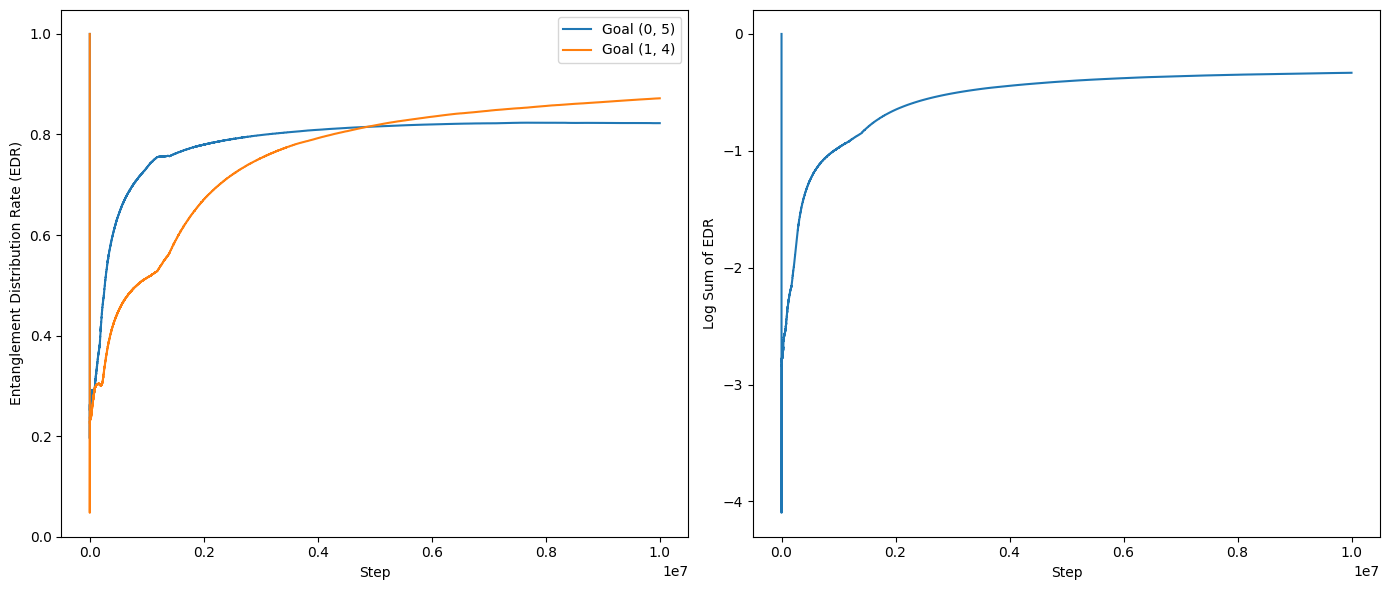

In [275]:
nodeCapacity = {
    0: 1,  
    1: 1,  
    2: 3,  
    3: 3, 
    4: 1,  
    5: 1
}
initialEdges = [
    (0, 2),
    (1, 2),
    (2, 3),
    (3, 4),
    (3, 5)]
goalEdgesAndWeights = [((0,5), 0.8), ((1,4), 0.2)]
setSeed = 27
random.seed(setSeed)
np.random.seed(setSeed)

gamma=0.99 # https://stackoverflow.com/a/46932284 gamma = 1 should just take largest reward... so we can debug
pGen=0.8
pSwap=1
cutOffAge=2
alpha=0.1
n=2
epsilon=0.1

total_steps = 10000000

edr_goal_1, edr_goal_2, log_sum_edr = nStepSARSA(
    initialEdges=initialEdges,
    nodeCapacity=nodeCapacity,
    goalEdgesAndWeights=goalEdgesAndWeights,
    gamma=gamma, 
    pGen=pGen,
    pSwap=pSwap,
    cutOffAge=cutOffAge,
    alpha=alpha,
    n=n,
    total_steps=total_steps,
    epsilon=epsilon
)
x_axis = range(total_steps)  # Create a range for the x-axis

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].plot(x_axis, edr_goal_1, label=f'Goal {goalEdgesAndWeights[0][0]}')
axs[0].plot(x_axis, edr_goal_2, label=f'Goal {goalEdgesAndWeights[1][0]}')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Entanglement Distribution Rate (EDR)')
axs[0].legend()

axs[1].plot(x_axis, log_sum_edr)
axs[1].set_xlabel('Step')
axs[1].set_ylabel('Log Sum of EDR')

plt.tight_layout()
plt.show()

# Random Policy

In [276]:
def randomPolicy(initialEdges, nodeCapacity, goalEdgesAndWeights, pGen, pSwap, cutOffAge, total_steps):
    # Initialize the environment
    network = WaitSwapEnvironment(
        initialEdges=initialEdges,
        pGen=pGen,
        pSwap=pSwap,
        cutOffAge=cutOffAge,
        nodeCapacity=nodeCapacity,
        goalEdgesAndWeights=goalEdgesAndWeights,
        n=n
    )
        
    # Logging for the EDR
    goal_1, goal_2 = goalEdgesAndWeights[0][0], goalEdgesAndWeights[1][0]
    edr_goal_1, edr_goal_2 = [], []
    log_sum_edr = []

    # Reset and prepare the network for a new run
    network.reset()
    network.generateGlobalEntanglementsProbabalistically()
    
    # Initial states and actions
    states = [network.getState()]
    action = random.choice(network.getPossibleActions())
    actions = [action]
    rewards = []
    
    for t in range(total_steps):
        # Take action A_{t}, and store next reward and state as R_{t+1}, S_{t+1}
        network.takeAction(actions[-1])
        states.append(network.getState())
        reward = network.getReward()
        rewards.append(reward)
        
        # Choose an action A_{t+1} arbitrarily as a function of S_{t+1}; Store as A_{t+1}
        action = random.choice(network.getPossibleActions())
        actions.append(action)
        
        # Take a step
        network.updateRateParameters()
        network.ageEntanglements()
        network.generateGlobalEntanglementsProbabalistically()
        
        # Logging
        edr_1 = network.sumExists[goal_1] / network.timestep
        edr_2 = network.sumExists[goal_2] / network.timestep
        edr_goal_1.append(edr_1)
        edr_goal_2.append(edr_2)            
        logReward = sum([np.log(edr_1), np.log(edr_2)])
        log_sum_edr.append(logReward)
        if t % 10000 == 0:
            print(t)

    return edr_goal_1, edr_goal_2, log_sum_edr

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
13

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10581f4d0>>
Traceback (most recent call last):
  File "/Users/berat/Desktop/quantum_entanglement/.venv/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


2850000
2860000
2870000
2880000
2890000
2900000
2910000
2920000
2930000
2940000
2950000
2960000
2970000
2980000
2990000
3000000
3010000
3020000
3030000
3040000
3050000
3060000
3070000
3080000
3090000
3100000
3110000
3120000
3130000
3140000
3150000
3160000
3170000
3180000
3190000
3200000
3210000
3220000
3230000
3240000
3250000
3260000
3270000
3280000
3290000
3300000
3310000
3320000
3330000
3340000
3350000
3360000
3370000
3380000
3390000
3400000
3410000
3420000
3430000
3440000
3450000
3460000
3470000
3480000
3490000
3500000
3510000
3520000
3530000
3540000
3550000
3560000
3570000
3580000
3590000
3600000
3610000
3620000
3630000
3640000
3650000
3660000
3670000
3680000
3690000
3700000
3710000
3720000
3730000
3740000
3750000
3760000
3770000
3780000
3790000
3800000
3810000
3820000
3830000
3840000
3850000
3860000
3870000
3880000
3890000
3900000
3910000
3920000
3930000
3940000
3950000
3960000
3970000
3980000
3990000
4000000
4010000
4020000
4030000
4040000
4050000
4060000
4070000
4080000
4090000


/var/folders/gg/2xgfrwhs60j8qg5zm5gbky_c0000gn/T/ipykernel_62583/1978162896.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


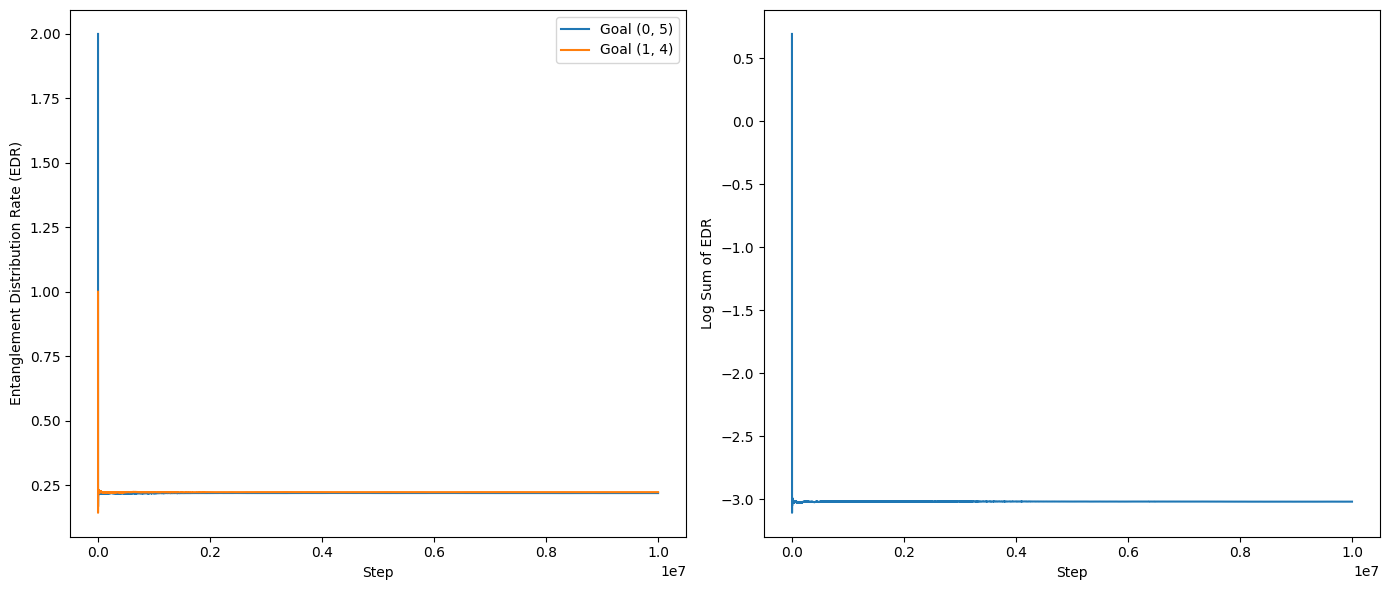

In [277]:
edr_goal_1_random, edr_goal_2_random, log_sum_edr_random = randomPolicy(
    initialEdges=initialEdges,
    nodeCapacity=nodeCapacity,
    goalEdgesAndWeights=goalEdgesAndWeights,
    pGen=pGen,
    pSwap=pSwap,
    cutOffAge=cutOffAge,
    total_steps=total_steps)
print(len(edr_goal_1_random), len(edr_goal_2_random), len(log_sum_edr_random), total_steps)
# Create a figure with two subplots side by side
x_axis = range(total_steps)  # Create a range for the x-axis

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].plot(x_axis, edr_goal_1_random, label=f'Goal {goalEdgesAndWeights[0][0]}')
axs[0].plot(x_axis, edr_goal_2_random, label=f'Goal {goalEdgesAndWeights[1][0]}')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Entanglement Distribution Rate (EDR)')
axs[0].legend()

axs[1].plot(x_axis, log_sum_edr_random)
axs[1].set_xlabel('Step')
axs[1].set_ylabel('Log Sum of EDR')

plt.tight_layout()
plt.show()

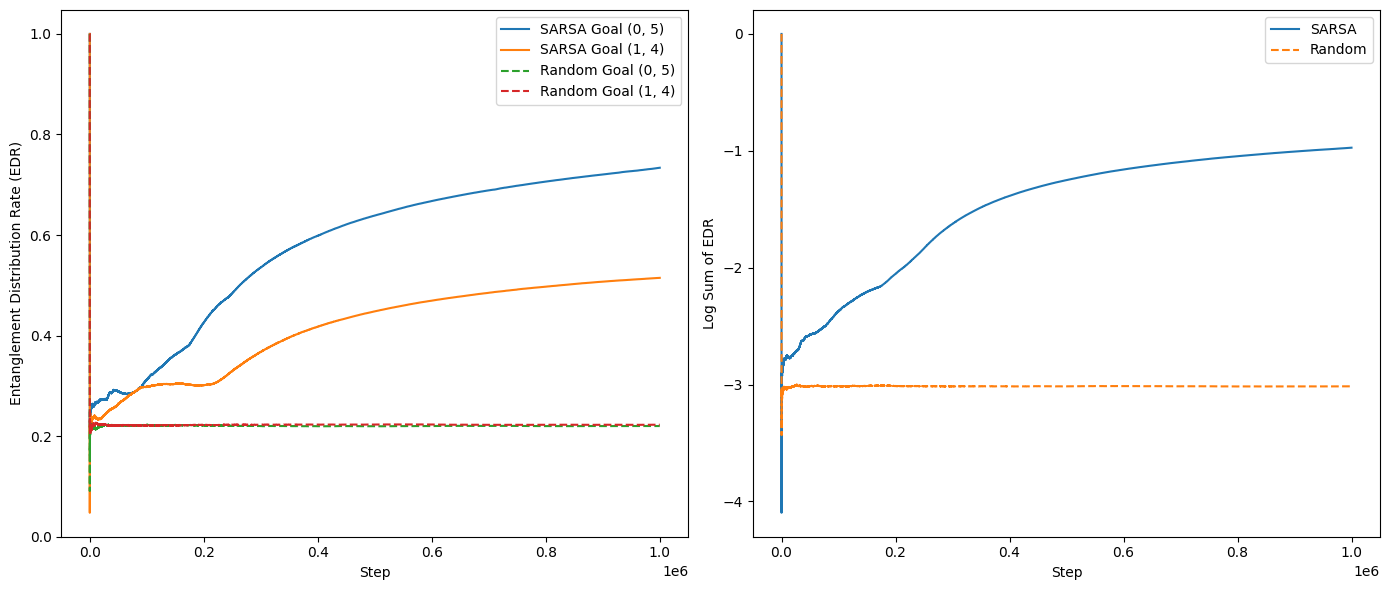

In [ ]:
# Create a figure with two subplots side by side
x_axis_sarsa = range(len(edr_goal_1))  # Create a range for the x-axis for SARSA
x_axis_random = range(len(edr_goal_1_random))  # Create a range for the x-axis for Random Policy

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Entanglement Distribution Rate (EDR)
axs[0].plot(x_axis_sarsa, edr_goal_1, label=f'SARSA Goal {goalEdgesAndWeights[0][0]}', linestyle='-')
axs[0].plot(x_axis_sarsa, edr_goal_2, label=f'SARSA Goal {goalEdgesAndWeights[1][0]}', linestyle='-')
axs[0].plot(x_axis_random, edr_goal_1_random, label=f'Random Goal {goalEdgesAndWeights[0][0]}', linestyle='--')
axs[0].plot(x_axis_random, edr_goal_2_random, label=f'Random Goal {goalEdgesAndWeights[1][0]}', linestyle='--')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Entanglement Distribution Rate (EDR)')
axs[0].legend()

# Plot for Log Sum of EDR
axs[1].plot(x_axis_sarsa, log_sum_edr, label='SARSA', linestyle='-')
axs[1].plot(x_axis_random, log_sum_edr_random, label='Random', linestyle='--')
axs[1].set_xlabel('Step')
axs[1].set_ylabel('Log Sum of EDR')
axs[1].legend()

plt.tight_layout()
plt.show()